__Purpose:__ Introduce Personalized Federated Learning, specifically by implementing APFL on our dataset and then trying other methods.
<br>
1. We are still assuming we can test on the second half (updates 10-19ish) since (human/co-adaptive) learning should be complete by then!  For reasons shown in earlier NBs

In [1]:
import pandas as pd
import os
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import copy

from experiment_params import *
from cost_funcs import *
from fl_sim_classes import *
import time
import pickle
from sklearn.decomposition import PCA

In [2]:
path = r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\Data'
cond0_filename = r'\cond0_dict_list.p'
all_decs_init_filename = r'\all_decs_init.p'
nofl_decs_filename = r'\nofl_decs.p'
id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
            7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}
implemented_client_training_methods = ['EtaGradStep', 'EtaScipyMinStep', 'FullScipyMinStep']
implement_these_methods_next = ['APFL', 'AFL', 'PersA_FL_MAML', 'PersA_FL_ME', 'PFA']
num_participants = 14

# For exclusion when plotting later on
bad_nodes = [1,3,13]

with open(path+cond0_filename, 'rb') as fp:
    cond0_training_and_labels_lst = pickle.load(fp)

D_0_7 = np.random.rand(2,7)

# Testing APFL

Testing the APFL Implementation
> Why does the client and global server need num_steps... is it not just set by the server?

Dynamic learning rate, adaptive off; USING REAL HESSIAN

In [3]:
np.random.seed(0)
user_c0_APFL_realhess_noeta = [Client(i, np.random.rand(2,7), 'NAN', cond0_training_and_labels_lst[i], 
                       'streaming', use_real_hess=True, adaptive=False, 
                       num_steps=10, global_method='APFL') for i in range(14)]
global_model_APFL_realhess_noeta = Server(1, np.random.rand(2,7), 'APFL', user_c0_APFL_realhess_noeta, num_steps=10)

big_loop_iters = 250
for i in range(big_loop_iters):
    if i%10==0:
        print(f"Round {i} of {big_loop_iters}")
    global_model_APFL_realhess_noeta.execute_FL_loop()
    
print()
print("(Current Local Round, Current Local Update)")
for my_client in global_model_APFL_realhess_noeta.all_clients:
    print((my_client.current_round, my_client.current_update))

Round 0 of 250
Client1: Recalculating the Hessian for new update 10!
Client6: Recalculating the Hessian for new update 10!
Round 10 of 250
Client9: Recalculating the Hessian for new update 10!
Client10: Recalculating the Hessian for new update 10!
Round 20 of 250
Round 30 of 250
Round 40 of 250
Client3: Recalculating the Hessian for new update 10!
Client7: Recalculating the Hessian for new update 10!
Round 50 of 250
Client13: Recalculating the Hessian for new update 10!
Round 60 of 250
Client0: Recalculating the Hessian for new update 10!
Round 70 of 250
Client2: Recalculating the Hessian for new update 10!
Round 80 of 250
Client12: Recalculating the Hessian for new update 10!
Round 90 of 250
Round 100 of 250
Round 110 of 250
Round 120 of 250
Round 130 of 250
Client11: Recalculating the Hessian for new update 10!
Round 140 of 250
Client6: Recalculating the Hessian for new update 11!
Round 150 of 250
Round 160 of 250
Client5: Recalculating the Hessian for new update 10!
Round 170 of 250

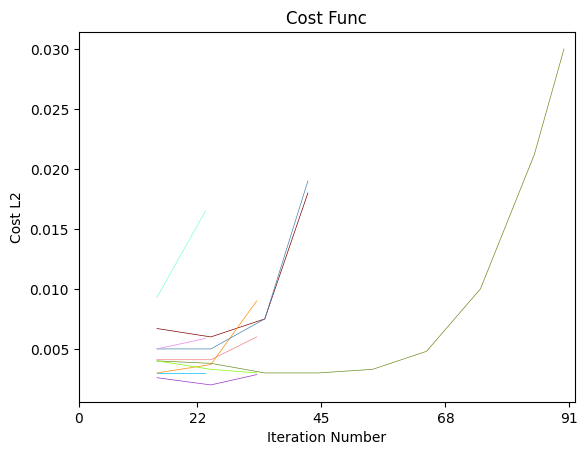

In [4]:
condensed_external_plotting(user_c0_APFL_realhess_noeta, 'local', global_error=False, dim_reduc_factor=10, show_update_change=False, custom_title='Cost Func')

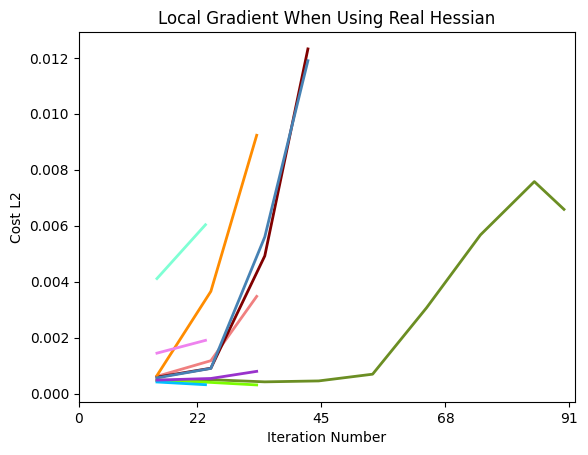

In [6]:
condensed_external_plotting(user_c0_APFL_realhess_noeta, 'local', plot_gradient=True, local_error=False, 
                            global_error=False, show_update_change=False, custom_title='Local Gradient When Using Real Hessian')

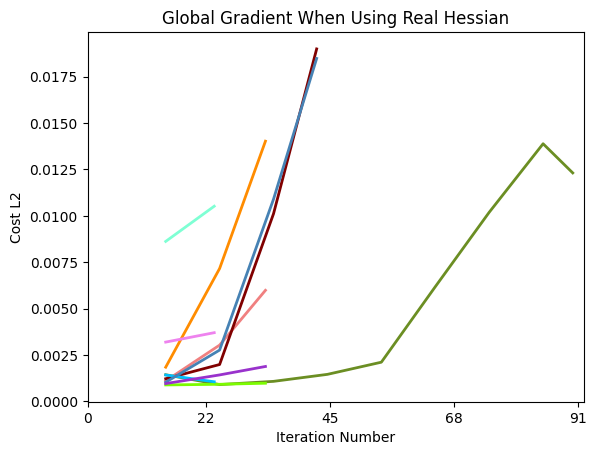

In [7]:
condensed_external_plotting(user_c0_APFL_realhess_noeta, 'local', plot_global_gradinet=True, local_error=False, 
                            global_error=False, show_update_change=False, custom_title='Global Gradient When Using Real Hessian')

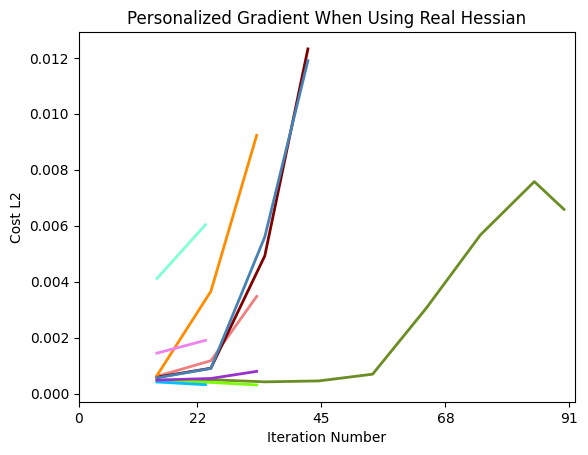

In [9]:
condensed_external_plotting(user_c0_APFL_realhess_noeta, 'local', plot_pers_gradient=True, local_error=False, 
                            global_error=False, show_update_change=False, custom_title='Personalized Gradient When Using Real Hessian')

In [14]:
u0 = user_c0_APFL_realhess_noeta[0]
print("Local vs Personalized Gradient")
print(np.array(u0.gradient_log) - np.array(u0.pers_gradient_log))
print("\nLocal vs Global Gradient")
print(np.array(u0.gradient_log) - np.array(u0.global_gradient_log))
print("\nPers vs Global Gradient")
print(np.array(u0.pers_gradient_log) - np.array(u0.global_gradient_log))

Local vs Personalized Gradient
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Local vs Global Gradient
[ 0.00000000e+00  3.94447422e-03 -3.70372215e-04 -2.81002775e-04
 -1.95771846e-04 -1.15371497e-04 -4.02135654e-05  2.95156647e-05
  9.38000947e-05  1.52745491e-04 -4.76903454e-04 -5.60121327e-04
 -4.88206065e-04 -4.16942469e-04 -3.47152592e-04 -2.79514939e-04
 -2.14549570e-04 -1.52625046e-04 -9.39774744e-05 -1.86105584e-03
 -1.24169462e-03 -1.20922247e-03 -1.17546735e-03 -1.14017874e-03
 -1.10308327e-03 -1.06389485e-03 -1.02233309e-03 -9.78152016e-04
 -7.02574440e-03 -2.64329778e-03 -2.61002973e-03 -2.57712340e-03
 -2.54455818e-03 -2.51231172e-03 -2.48035953e-03 -2.44867446e-03
 -2.41722617e-03]

Pers vs Global Gradient
[ 0.00000000e+00  3.94447422e-03 -3.70372215e-04 -2.81002775e-04
 -1.95771846e-04 -1.15371497e-04 -4.02135654e-05  2.95156647e-05
  9.38000947e-05  1.52745491e-04 -4.76903454e-04 -5.60121327e-04
 -4.88

In [ ]:
u0.

Bruh

Dynamic learning rate, adaptive ON; USING REAL HESSIAN

In [ ]:
np.random.seed(0)
user_c0_APFL_realhess_adapt = [Client(i, np.random.rand(2,7), 'NAN', cond0_training_and_labels_lst[i], 
                       'streaming', use_real_hess=True, adaptive=True, 
                       num_steps=10, global_method='APFL') for i in range(14)]
global_model_APFL_realhess_adapt = Server(1, np.random.rand(2,7), 'APFL', user_c0_APFL_realhess_adapt, num_steps=10)

big_loop_iters = 250
for i in range(big_loop_iters):
    if i%10==0:
        print(f"Round {i} of {big_loop_iters}")
    global_model_APFL_realhess_adapt.execute_FL_loop()
    
print()
print("(Current Local Round, Current Local Update)")
for my_client in global_model_APFL_realhess_adapt.all_clients:
    print((my_client.current_round, my_client.current_update))

In [ ]:
condensed_external_plotting(user_c0_APFL_realhess_adapt, 'local', global_error=False, dim_reduc_factor=10, show_update_change=False, custom_title='(Adaptive) Cost Func')

In [ ]:
condensed_external_plotting(user_c0_APFL_realhess_adapt, 'local', plot_gradient=True, local_error=False, 
                            global_error=False, show_update_change=False, custom_title='(Adaptive) Gradient When Using Real Hessian')

Dynamic learning rate, adaptive off; USING REAL HESSIAN

Learning rate of 1e-10, adaptive off

In [ ]:
user_c0_APFL_eta_m10 = [Client(i, D_0_7, 'NAN', cond0_training_and_labels_lst[i], 
                       'streaming', eta=1e-10, input_eta=True, gradient_clipping=True, adaptive=False, 
                       num_steps=10, global_method='APFL') for i in range(14)]
global_model_APFL_eta_m10 = Server(1, D_0_7, 'APFL', user_c0_APFL_eta_m10, num_steps=10)

big_loop_iters = 500
for i in range(big_loop_iters):
    if i%10==0:
        print(f"Round {i} of {big_loop_iters}")
    global_model_APFL_eta_m10.execute_FL_loop()
    
print("(Current Local Round, Current Local Update)")
for my_client in global_model_APFL_eta_m10.all_clients:
    print((my_client.current_round, my_client.current_update))


In [ ]:
condensed_external_plotting(user_c0_APFL_eta_m10, 'local', global_error=False, dim_reduc_factor=10, show_update_change=False, custom_title='Eta=1e-10 Cost Func')

In [ ]:
condensed_external_plotting(user_c0_APFL_eta_m10, 'local', plot_gradient=True, local_error=False, 
                            global_error=False, show_update_change=False, custom_title='Eta=1e-10 Gradient')

Safe Learning Rate APFL (Adaptive Off)
> Gradient clipping appaers to be failing

In [ ]:
user_c0_APFL_slr_15 = [Client(i, D_0_7, 'NAN', cond0_training_and_labels_lst[i], 
                       'streaming', safe_lr=15, adaptive=False, gradient_clipping=True, num_steps=10, 
                       global_method='APFL') for i in range(14)]
global_model_APFL_slr_15 = Server(1, D_0_7, 'APFL', user_c0_APFL_slr_15, num_steps=10)
global_model_APFL_slr_15.execute_FL_loop()

In [ ]:
big_loop_iters = 1000
for i in range(big_loop_iters):
    global_model_APFL_slr_15.execute_FL_loop()
    
print("(Current Local Round, Current Local Update)")
for my_client in global_model_APFL_slr_15.all_clients:
    print((my_client.current_round, my_client.current_update))

In [ ]:
condensed_external_plotting(user_c0_APFL_slr_15, 'local', plot_gradient=True, local_error=False, 
                            global_error=False, show_update_change=False, custom_title='Safe Learning Rate 1/15L Gradient')

Vanilla APFL
> Adaptive is on!

In [ ]:
user_c0_APFL = [Client(i, D_0_7, 'NAN', cond0_training_and_labels_lst[i], 'streaming', num_steps=10, gradient_clipping=True, global_method='APFL') for i in range(14)]
global_model_APFL = Server(1, D_0_7, 'APFL', user_c0_APFL, num_steps=10)
global_model_APFL.execute_FL_loop()

In [ ]:
big_loop_iters = 1000
for i in range(big_loop_iters):
    global_model_APFL.execute_FL_loop()
    
print("(Current Local Round, Current Local Update)")
for my_client in global_model_APFL.all_clients:
    print((my_client.current_round, my_client.current_update))

In [ ]:
condensed_external_plotting(user_c0_APFL, 'local', plot_gradient=True, local_error=False, 
                            global_error=False, show_update_change=False, custom_title='Eta=10 Gradient')

In [ ]:
condensed_external_plotting(user_c0_APFL, 'local', plot_gradient=True, local_error=False,
                            global_error=False, show_update_change=False, custom_title='Eta=10 Gradient')

In [ ]:
i = global_model_APFL.chosen_clients_lst[0].ID
user_c0_APFL[i].personalized_error_log[-1]#[user_c0_APFL[i].ID]#[2]

^ Int is not subscriptable!
> Personalized_error_log is not being updated!

In [ ]:
eigvals, eigvecs = np.linalg.eig(user_c0_APFL[i].F.T@user_c0_APFL[i].F)
eigvals[:10]

In [ ]:
mu = np.amin(eigvals)
L = np.amax(eigvals)
print(f"mu: {mu}")
print(f"L: {L.round(3)}")
if mu.real < 1e-10:
    mu = 1e-3
    print(f"New mu: {mu}")
kappa = L/mu
print(f"kappa: {kappa.round(3)}")

# tau is 10 in the above run, for now
a = np.max([128*kappa, 10])  # Max works on an array input, not multiple inputs
eta_t = 16 / (mu*(1+a))
print(f"a: {a.round(3)}")
print(f"eta_t: {eta_t.round(6)}")
print(f"1/2L: {(1/(2*L)).round(6)}")

In [ ]:
lr_limit = 1/(2*L)
print(lr_limit)

In [ ]:
safe_lr_limit = 1/(10*L)
print(safe_lr_limit)

In [ ]:
eigvals_rounded = eigvals.round(7)

print("10 Eigs")
print(eigvals_rounded[:10])
print("Mu (min eigval)")
print(np.amin(eigvals_rounded))
print("L (max eigval)")
print(np.amax(eigvals_rounded))

In [ ]:
eigvals_inplace = copy.copy(eigvals)
eps = 1e-7

eigvals_inplace[np.abs(eigvals_inplace) < eps] = 0

print("10 Eigs")
print(eigvals_inplace[:10])
print("Mu (min eigval)")
print(np.amin(eigvals_inplace))
print("L (max eigval)")
print(np.amax(eigvals_inplace))

In [ ]:
eigvals_ReIm = copy.copy(eigvals)
tol = 1e-7

eigvals_ReIm.real[abs(eigvals_ReIm.real) < tol] = 0.0
eigvals_ReIm.imag[abs(eigvals_ReIm.imag) < tol] = 0.0

print("10 Eigs")
print(eigvals_ReIm[:10])
print("Mu (min eigval)")
print(np.amin(eigvals_ReIm))
print("L (max eigval)")
print(np.amax(eigvals_ReIm))

Doing the reverse transposed order, this is supposed to be the same FOR REAL SQUARE MATRICES ONLY.  F is not square though...

In [ ]:
eigvals2, eigvecs2 = np.linalg.eig(user_c0_APFL[i].F@user_c0_APFL[i].F.T)
mu2 = np.amin(eigvals2)
L2 = np.amax(eigvals2)

print(f"First 10 eigs: \n {eigvals2[:10]}\n")
print(f"mu2: {mu2}")
print(f"L2: {L2}")

Misc stuff idk

In [ ]:
#i = 0
# This should be the same i as the above loop

print(f"F.shape: {user_c0_APFL[i].F.shape}")
print(f"Norm: {np.linalg.norm(user_c0_APFL[i].F)}")
print(f"Sum: {np.sum((user_c0_APFL[i].F))}")
print(f"**2 Sum: {np.sum((user_c0_APFL[i].F)**2)}")

In [ ]:
hess = user_c0_APFL[i].F@user_c0_APFL[i].F.T
np.linalg.eig(hess)

In [ ]:
print("Decs")
print(user_c0_APFL[i].local_w)
print(user_c0_APFL[i].global_w)
diff = user_c0_APFL[i].local_w - user_c0_APFL[i].global_w
print(diff)
print()
print("Gradient")
out = gradient_cost_l2(user_c0_APFL[i].F, user_c0_APFL[i].mixed_w, user_c0_APFL[i].H, user_c0_APFL[i].V, user_c0_APFL[i].learning_batch, user_c0_APFL[i].alphaF, user_c0_APFL[i].alphaD, Ne=7)
print(out.shape)
print(out)

In [ ]:
np.inner(diff.flatten(), out.flatten())

Look at Vanilla APFL Run

In [ ]:
user_c0_APFL[0].adap_alpha[:22]

In [ ]:
print(f"F.shape: {user_c0_APFL[0].F.shape}")
print(f"Norm: {np.linalg.norm(user_c0_APFL[0].F)}")
print(f"Sum: {np.sum((user_c0_APFL[0].F))}")
print(f"**2 Sum: {np.sum((user_c0_APFL[0].F)**2)}")

In [ ]:
print(user_c0_APFL[0].local_w)
print(user_c0_APFL[0].global_w)
diff = user_c0_APFL[0].local_w - user_c0_APFL[0].global_w
print(diff)
out = gradient_cost_l2(user_c0_APFL[0].F, user_c0_APFL[0].mixed_w, user_c0_APFL[0].H, user_c0_APFL[0].V, user_c0_APFL[0].learning_batch, user_c0_APFL[0].alphaF, user_c0_APFL[0].alphaD, Ne=7)
print(out.shape)
print(out)

In [ ]:
np.inner(diff.flatten(), out.flatten())

Plot

In [ ]:
condensed_external_plotting(user_c0_APFL, 'local', pers_error=True, show_update_change=False, custom_title="APFL: Global, Local, and Pers Costs Per Iter")

In [ ]:
condensed_external_plotting(global_model_APFL, 'global', pers_error=True, show_update_change=False, custom_title="APFL: Global and Local Costs Per Iteration")

In [ ]:
condensed_external_plotting(user_c0_APFL, 'local', plot_gradient=True, local_error=False, global_error=False, show_update_change=False, custom_title='GRADIENT')

In [ ]:
global_model_APFL.current_round

In [ ]:
#client_loss.append(input_data.global_error_log[j][i][2])
len(global_model_APFL.global_error_log)

In [ ]:
len(global_model_APFL.local_error_log)

In [ ]:
len(global_model_APFL.personalized_error_log)

In [ ]:
assert(1==0)

# DEVELOPMENT

# Personalized FL Algorithms
ALL PERSONALIZATION ALGORITHMS
1. APFL
1. Cesar/Taha: AFL + PARS-PUSH
1. PFA: PP F Adaptation for Effective Model Personalization
1. Pers RT FL for Epileptic Seizure Detection
1. An Efficient Framework for Clustered FL
1. Pers FL with DP
## Adaptive Personalized FL Testing Ground

Adapting their code to actually be able to be run in something other than top-down server-only approach
> Their Github: https://github.com/MLOPTPSU/FedTorch <br>
> APFL link: https://github.com/MLOPTPSU/FedTorch/blob/ab8068dbc96804a5c1a8b898fd115175cfebfe75/fedtorch/comms/trainings/federated/apfl.py#L33

loss.backward() computes dloss/dx for every parameter x which has requires_grad=True. These are accumulated into x.grad for every parameter x. Loss.backward() does not update the weights, only computes the gradients.  The graph is used by loss.backward() to compute gradients.  In pseudo-code: x.grad += dloss/dx

optimizer.step updates the value of x using the gradient x.grad. For example, the SGD optimizer performs:

x += -lr * x.grad
optimizer.zero_grad() clears x.grad for every parameter x in the optimizer. It’s important to call this before loss.backward(), otherwise you’ll accumulate the gradients from multiple passes.

optimizer.zero_grad() and optimizer.step() do not affect the graph of autograd objects. They only touch the model’s parameters and the parameter’s grad attributes.

If you have multiple losses (loss1, loss2) you can sum them and then call backwards once:

loss3 = loss1 + loss2
loss3.backward()

In [ ]:
#python run_mpi.py -f -ft apfl -n 10 -d mnist -lg 0.1 -b 50 -c 20 -k 1.0 -fs local_step -l 10 -r 2 -pa 0.5 -fp
#'--num_epochs': args.num_epochs_per_comm * args.num_comms,

# num_epochs_per_comm=1
# num_clients=20
# batch_size=50
# num_comms=100
# lr_gamma=1.0
# lr_mu = 1